## Preparation

In [1]:
# imports
import data_check
import json

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import trange

import numpy as np

import keras

In [2]:
# main folder
main_folder = "I:\\Svago\\A2D2_segmentation\\"

global_path = main_folder + "Data_clean/"

camera_path = global_path + "camera/"
label_path = global_path + "label/"

### Data check

In [3]:
# retrieve color dict
with open(main_folder + "code/colori_classi_label_hex.json", "r") as f:
    colori_classi_label_hex = json.load(f)
    # if success
    print("Color dict loaded successfully!")

Color dict loaded successfully!


In [4]:
classColor_idx_dict = {}

for idx, label in enumerate(colori_classi_label_hex.values(), start=0):
    classColor_idx_dict[label] = idx
    # Label : idx

In [5]:
# check data
camera_imgs_list_names, label_imgs_list_names = data_check.get_folders_list(camera_path, label_path)

Ottengo la lista di nomi dei file ...
Lista nomi immagini popolata
Lista nomi labels popolata
Il numero di immagini è lo stesso ( 39933 )
I nomi dei file sono uguali

 EVERYTHING OK


In [6]:
# check labels
data_check.check_label(label_path, label_imgs_list_names[0], colori_classi_label_hex)

numero di buchi:  0

 EVERYTHING OK


In [7]:
# so, if it's all ok, we can define the number of classes
num_classes = len(colori_classi_label_hex)

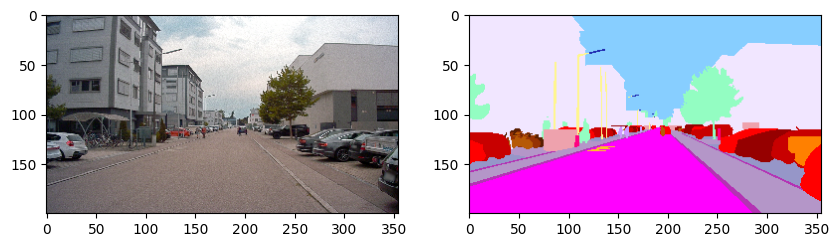

In [8]:
# visualize an image an its label
img = Image.open(camera_path + camera_imgs_list_names[0])
img = np.asarray(img)
label = Image.open(label_path + label_imgs_list_names[0])
label = np.asarray(label)

plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(label)
plt.show()

### OneHot encoding

In [9]:
# given a label we convert it to an array one-hot encoded

def label_to_onehot(label, num_classes):
    # we are assuming that a label is a 3D array where the third dimension is the color of the classes
    # we have to convert it to a 3D array where the third dimension is the number of classes and only one channel is 1

    # create the one-hot array
    onehot_label = np.zeros((label.shape[0], label.shape[1], num_classes), dtype=np.uint8)

    # for each row
    for row in range(label.shape[0]):
        # for each column
        for col in range(label.shape[1]):
            # get the pixel color
            pixel_color = tuple(label[row, col])
            pixel_color = '#{:02X}{:02X}{:02X}'.format(pixel_color[0], pixel_color[1], pixel_color[2]).lower()
            
            # get the name of the class
            class_name = colori_classi_label_hex[pixel_color]

            # get the index of the class
            idx = classColor_idx_dict[class_name]

            # set the one-hot encoding
            onehot_label[row, col, idx] = 1

    # argmax
    onehot_label = np.argmax(onehot_label, axis=-1)

    # expand dims
    onehot_label = np.expand_dims(onehot_label, axis=-1)
    
    return onehot_label


213000
(200, 355, 3)
(200, 355, 1)


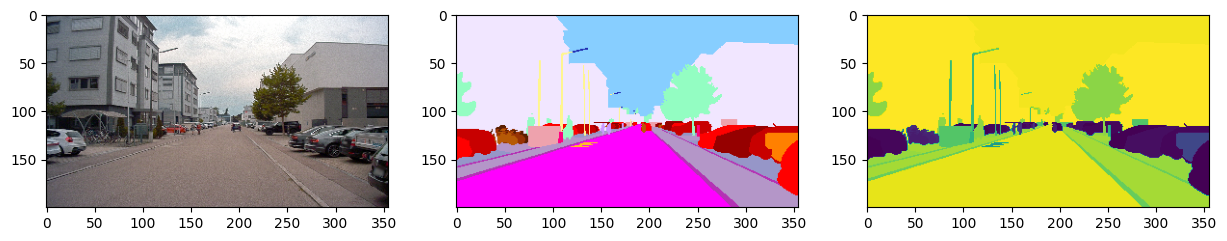

In [10]:
# visualize an image, its label and its one-hot encoded label
img = Image.open(camera_path + camera_imgs_list_names[0])
img = np.asarray(img, dtype=np.uint8)
print(img.nbytes)
print(img.shape)
label = Image.open(label_path + label_imgs_list_names[0])
label = np.asarray(label)

onehot_label = label_to_onehot(label, num_classes)
# convert the one-hot label to an imageù

print(onehot_label.shape)


plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(label)
plt.subplot(1,3,3)
plt.imshow(onehot_label)
plt.show()

## Generator

loading all the images into a variable

In [11]:
img_shape = np.asarray(Image.open(camera_path + camera_imgs_list_names[0])).shape
label_encoded_shape = label_to_onehot(np.asarray(Image.open(label_path + label_imgs_list_names[0])), num_classes).shape

In [12]:
# function that yealds a single image and its encoded label
def data_generator(camera_path, label_path, camera_imgs_list_names, label_imgs_list_names, num_classes):
    batch_img_shape = list(img_shape)
    batch_img_shape.insert(0, len(camera_imgs_list_names))
    camera_imgs = np.empty(batch_img_shape, dtype=np.uint8)
    label_img_shape = list(label_encoded_shape)
    label_img_shape.insert(0, len(label_imgs_list_names))
    label_imgs = np.empty(label_img_shape, dtype=np.uint8)
    for i in trange(0, len(camera_imgs_list_names)):
        camera_img = Image.open(camera_path + camera_imgs_list_names[i])
        camera_img = np.asarray(camera_img, dtype=np.uint8)
        label_img = Image.open(label_path + label_imgs_list_names[i])
        label_img = np.asarray(label_img, dtype=np.uint8)

        #encoding
        onehot_label = label_to_onehot(label_img, num_classes)
        camera_imgs[i] = camera_img
        label_imgs[i] = onehot_label

    return camera_imgs, label_imgs

In [13]:
# check if the data is already saved
try:
    camera_imgs = np.load(main_folder + "Data_clean/camera_imgs_numpy_array.npy")
    label_imgs = np.load(main_folder + "Data_clean/label_encoded_imgs_numpy_array.npy")
    print("Data loaded successfully!")
except:
    print("Data not found, generating it...")
    camera_imgs, label_imgs = data_generator(camera_path, label_path, camera_imgs_list_names, label_imgs_list_names, num_classes)
    print("Data generated successfully!")
    np.save(main_folder + "Data_clean/camera_imgs_numpy_array.npy", camera_imgs)
    np.save(main_folder + "Data_clean/label_encoded_imgs_numpy_array.npy", label_imgs)
    print("Data saved successfully!")

Data loaded successfully!


## Preprocess

## Training

In [14]:
# convolutiona nn

from keras.models import Sequential
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape, Permute

model = Sequential(
    [
        Input(shape=img_shape),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        UpSampling2D((2, 2)),
        Conv2DTranspose(16, (3, 3), activation='relu', padding='same'),
        Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        Permute((2, 1, 3)),
        Conv2DTranspose(355, (1, 1), activation='relu', padding='same', data_format='channels_first'),
        Permute((2, 1, 3)),
        Conv2D(num_classes, (3,3), activation='softmax', padding='same')
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 355, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 200, 355, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 200, 355, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 177, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 177, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 177, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 177, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 88, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 50, 88, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 44, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 25, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 44, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 88, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 50, 88, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 88, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 176, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 100, 176, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 176, 64)   │        18,496 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 200, 352, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 200, 352, 16)   │         9,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 352, 64)   │         9,280 │
│ (Conv2DTranspose)               │                        │             

 Total params: 665,258 (2.54 MB)

 Trainable params: 665,258 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(camera_imgs, label_imgs, epochs=4, batch_size=32, initial_epoch=0)

Epoch 1/4
 234/1248 ━━━━━━━━━━━━━━━━━━━━ 2:47:47 10s/step - accuracy: 0.3570 - loss: 2.3360

KeyboardInterrupt: 

In [ ]:
# save the model
model.save(main_folder + "models/segmentation_model_002.h5")

In [20]:
# load the model
model = keras.models.load_model(main_folder + "models/segmentation_model_001.h5")

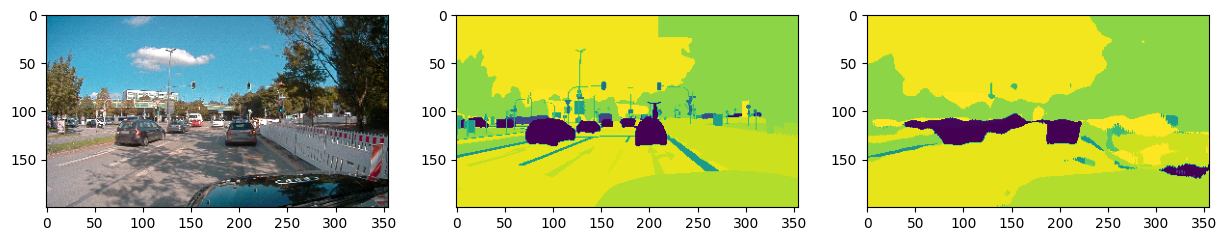

In [26]:
# take a random image from the dataset
idx = np.random.randint(0, len(camera_imgs))

# predict on a single image from the dataset
prediction = model(camera_imgs[idx:idx+1])
prediction = np.argmax(prediction, axis=-1)

# visualize the prediction and the original image and label
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(camera_imgs[idx])
plt.subplot(1,3,2)
plt.imshow(label_imgs[idx])
plt.subplot(1,3,3)
plt.imshow(prediction[0])
plt.show()